# Post statistical analyses demo

- Multivariate analyses (model weight based)

In [9]:
import glob
import sklearn
import scipy.io as sio
from scipy.spatial.distance import squareform
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mne_connectivity.viz import plot_connectivity_circle
from mne.viz import circular_layout

import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import re
from pylab import *
##############################################################
# Draw chord maps
import os
import sys

# work dir
root_dir = '/Users/fiona/Junhao/Project/BNU_SHFE'
sys.path.append(root_dir + '/Final_Version/Code/io_')
import io_
# another chord plot
# https://github.com/moshi4/pyCirclize
# https://jokergoo.github.io/circlize_book/book/advanced-usage-of-chorddiagram.html
# https://jokergoo.github.io/2020/06/08/multiple-group-chord-diagram/

## The function of chord plot

In [13]:
# def squareform_weights(weight_file):
#     df_mat = sio.loadmat(weight_file)
#     weights = df_mat['mean']
#     # remove the constance
#     weights = weights[0,1::]
#     sys_weights = squareform(weights, force='no', checks=True)
#     return sys_weights

# select the top-k weights
def topN_ind(arr, topN):
    return(arr.argsort()[-topN:][::-1])

def creat_label_names(BNA_file):
    df_bna = pd.read_excel(BNA_file)
    BNA_Lobes = df_bna['Lobe_M']
    Lobes_Gyrus = df_bna['Gyrus_M']
    label_names = []
    for i in np.arange(len(BNA_Lobes)):
        label_names.append(BNA_Lobes[i].strip() + '_' + Lobes_Gyrus[i] + '-' + str(i))
    
    # for circle split
    Lobe_start_index = df_bna['Lobe'].dropna().index.to_numpy()
    
    return label_names, Lobe_start_index

def plot_chord(cmat, label_names, Lobe_start_index, N_lines, lut_file, color_range, saveFormat='png', save_dir = None):
    
    node_order = label_names
    group_boundaries = Lobe_start_index
    node_angles = circular_layout(label_names, node_order, start_pos = 0, group_boundaries = group_boundaries, group_sep = 5)

    # plot
    lut = sio.loadmat(lut_file)
    lut_9 = lut['hsv_lut_9']
    colors = lut_9[0:9,:]
    colors[2, :] = np.array([0.863, 0.957, 0.008, 1])
    colors[0,:] = np.array([0.808,0.066,0.348,1])
    colors[8, :] = np.array([1, 0, 0, 1])

    node_colors= np.zeros((len(label_names),4))
    for i, ind_i in enumerate(Lobe_start_index):
        if ind_i < np.max(np.array(Lobe_start_index)):
            ind_i_1 = Lobe_start_index[i+1]
            node_colors[ind_i:ind_i_1,:] = lut_9[i,:]
        else:
            node_colors[ind_i_1:len(label_names),:] = lut_9[i,:]


    #N_lines = 50
    Colorbar_pos = (-0.5,0.5)
    saveFormat =  saveFormat
    fig = plt.figure(num=None, figsize=(13, 13), facecolor='white')
    plot_connectivity_circle(cmat, label_names, n_lines=N_lines, fig=fig, node_colors = list(node_colors), node_angles= node_angles, colorbar=True, vmin = color_range[0], vmax = color_range[1], colorbar_pos=Colorbar_pos, colormap = 'RdYlBu_r', subplot=111, facecolor='white', textcolor='black',node_edgecolor='black',linewidth=1.0,node_linewidth=0.5)

    # save
    if save_dir is not None:
        saveFormat =  saveFormat
        fig.savefig(save_dir, facecolor='white', dpi=1000, format=saveFormat)
        
    plt.close()

## Main
def chord_main(weights, N_lines, color_range, saveFormat = 'png', save_dir = None):    
    # weights: (7503,)   
    BNA_file = root_dir + '/Final_Version/RAW/BNA/BNA_subregions.xlsx'
    lut_file = root_dir + '/Final_Version/RAW/hsv_lut_9.mat'
    
    sys_weights = squareform(weights, force='no', checks=True)
    label_names, Lobe_start_index = creat_label_names(BNA_file)
    
    plot_chord(sys_weights, label_names, Lobe_start_index, N_lines, lut_file, color_range, saveFormat, save_dir)
     

## Multivariate analyses

### 1. Read the model weights

In [11]:

# lambda=5, view the weight map
# HCP
# male
file_h0 = '/Users/fiona/Junhao/Project/BNU_SHFE/Final_Version/RAW/model_stats/first-order/L5G0.mat.mat'
# female
file_h1 = '/Users/fiona/Junhao/Project/BNU_SHFE/Final_Version/RAW/model_stats/first-order/L5G1.mat.mat'
## male and female difference based model weights
file_h2 = '/Users/fiona/Junhao/Project/BNU_SHFE/Final_Version/RAW/model_stats/second-order/L5G0_vs_L5G1.mat'

wh_m= sio.loadmat(file_h0)['mean'][0,1::] # male, removing the constant, dimension: 7503
wh_f = sio.loadmat(file_h1)['mean'][0,1::] # female
wh_2 = sio.loadmat(file_h2)['mean'][0,1::] # second-order weights

## GSP 
# male
file_g0 = '/Users/fiona/Junhao/Project/BNU_SHFE/Final_Version/validation_study/gsp/model_stats/L5G0.mat.mat'
# female
file_g1 = '/Users/fiona/Junhao/Project/BNU_SHFE/Final_Version/validation_study/gsp/model_stats/L5G1.mat.mat'

## male and female difference based model weights
file_g2 = '/Users/fiona/Junhao/Project/BNU_SHFE/Final_Version/validation_study/gsp/model_stats/L5G0_vs_L5G1.mat'

wg_m = sio.loadmat(file_g0)['mean'][0,1::] # male
wg_f = sio.loadmat(file_g1)['mean'][0,1::] # female
wg_2 = sio.loadmat(file_g2)['mean'][0,1::] # second-order weights

### 2. Chord plot
Note: Top 5% thresholded mask based on the **absolute model weights**.


#### 2.1 The second-order mask
- The top 5% absolute model weights from the second-order were masked in.
- The overlap between the hcp and gsp served as the final second-order mask.

/Users/fiona/opt/anaconda3/lib/python3.9/site-packages/mne/viz/circle.py:266: RuntimeWarning: invalid value encountered in true_divide
  con_val_scaled = (con - vmin) / vrange


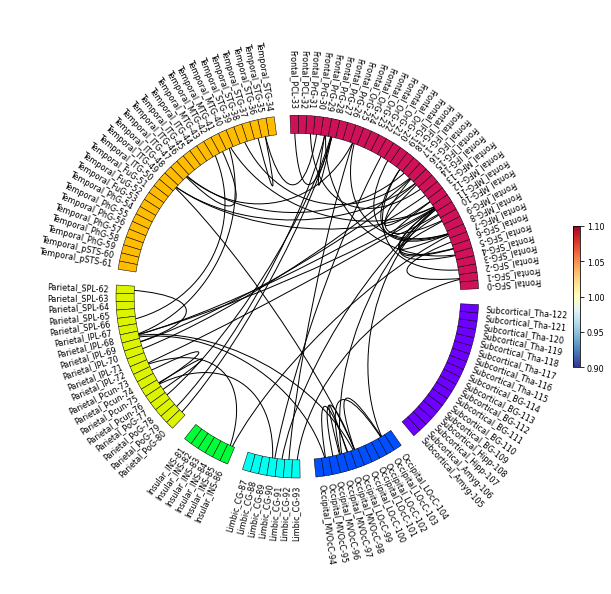

In [15]:
# Top 5% of the second-order weights
thr = 0.05
topN = round(7503*thr) # 7503 is the dimension of the feature.
# M and F
wh_thr2 = topN_ind(np.abs(wh_2), topN) # 2阶
wg_thr2 = topN_ind(np.abs(wg_2), topN) # 2阶
ind_olp = np.intersect1d(wh_thr2, wg_thr2) # overlap hcp and gsp

# save second-mask 
ind_olp.shape
whg_mask = np.zeros((len(wh_m),))
whg_mask[ind_olp] = 1
dataset = 'HCP-GSP_second-mask-overlap'
save_dir = '/Users/fiona/Junhao/Project/BNU_SHFE/Final_Version/Result/Figs_0717/multivariate/' + dataset + '_Chord_Top_' + str(thr) + '.svg' 
# save_dir = None
chord_main(whg_mask, 1, color_range = [None, None], saveFormat = 'svg', save_dir = save_dir)

#### 2.2 Edge names of the second-order mask

In [ ]:
whg_mask_prox = whg_mask.copy()
whg_mask_prox[whg_mask==1] = np.arange(np.sum(whg_mask)) + 1
np.unique(whg_mask_prox)

sys_whg_mask = squareform(whg_mask_prox, force='no', checks=True)
BNA_file = root_dir + '/Final_Version/RAW/BNA/BNA_subregions.xlsx'
label_names, Lobe_start_index = creat_label_names(BNA_file)

# extract edge names
df_edge = pd.DataFrame(columns = ['node1_name', 'node2_name','edge_name', 'edge_value'])
sys_mat = sys_whg_mask
fname = 'hcp_gsp_second_overlap_mask'
vals = np.unique(sys_mat[sys_mat!=0])

for k, val in enumerate(vals):
    ind = np.where(sys_mat==val)
    ind_1 = ind[0][0]
    ind_2 = ind[0][1]
    
    node1_name = label_names[ind_1]
    node2_name = label_names[ind_2]
    edge_name = node1_name + '-' + node2_name
    
    df_edge.loc[k, 'node1_name'] = node1_name
    df_edge.loc[k, 'node2_name'] = node2_name
    df_edge.loc[k, 'edge_name'] = edge_name
    df_edge.loc[k, 'edge_value'] = 1
    
# save

df_edge.to_csv('/Users/fiona/Junhao/Project/BNU_SHFE/Final_Version/Result/Figs_0717/brain_net/edge_vals/' + fname + '.csv', index = False)

### 3. First-order weights within the second-order mask
- Top 5% first-order absolute model weights.
- Within the second-order mask.
- The final original first-order model weights.

#### HCP Chord

In [ ]:
# HCP-m
wh_m_th1 = topN_ind(np.abs(wh_m), topN) # absolute, first-order
wh_ind_olp_m = np.intersect1d(ind_olp, wh_m_th1) # overlap index with the second-order mask

# HCP-f
wh_f_th1 = topN_ind(np.abs(wh_f), topN)
wh_ind_olp_f = np.intersect1d(ind_olp, wh_f_th1)

wh_m_olp = np.zeros((len(wh_m),))
wh_m_olp[wh_ind_olp_m] = wh_m[wh_ind_olp_m] # the oringal first-order masked model weights.

wh_f_olp = np.zeros((len(wh_f),))
wh_f_olp[wh_ind_olp_f] = wh_f[wh_ind_olp_f]

dataset_m = 'HCP_OverlapMaskBased-first-M'

save_dir_m = '/Users/fiona/Junhao/Project/BNU_SHFE/Final_Version/Result/Figs_0717/multivariate/' + dataset_m + '_Chord_Top_' + str(thr) + '.svg' 
chord_main(wh_m_olp, wh_ind_olp_m.shape[0], [-0.15,0.15], saveFormat = 'svg', save_dir = save_dir_m)

dataset_f = 'HCP_OverlapMaskBased-first-F'
save_dir_f = '/Users/fiona/Junhao/Project/BNU_SHFE/Final_Version/Result/Figs_0717/multivariate/' + dataset_f + '_Chord_Top_' + str(thr) + '.svg' 
chord_main(wh_f_olp, wh_ind_olp_f.shape[0], [-0.15,0.15], saveFormat = 'svg', save_dir = save_dir_f)


#### GSP Chord

In [ ]:
# GSP-m
wg_m_th1 = topN_ind(np.abs(wg_m), topN) # absolute, first-order
wg_ind_olp_m = np.intersect1d(ind_olp, wg_m_th1) # overlap index with the second-order mask


# GSP-f
wg_f_th1 = topN_ind(np.abs(wg_f), topN)
wg_ind_olp_f = np.intersect1d(ind_olp, wg_f_th1)

wg_m_olp = np.zeros((len(wg_m),))
wg_m_olp[wg_ind_olp_m] = wg_m[wg_ind_olp_m] # the oringal first-order masked model weights.

wg_f_olp = np.zeros((len(wg_f),))
wg_f_olp[wg_ind_olp_f] = wg_f[wg_ind_olp_f]

dataset_m = 'GSP_OverlapMaskBased-first-M'

save_dir_m = '/Users/fiona/Junhao/Project/BNU_SHFE/Final_Version/Result/Figs_0717/multivariate/' + dataset_m + '_Chord_Top_' + str(thr) + '.svg' 
chord_main(wg_m_olp, wg_ind_olp_m.shape[0], [-0.15,0.15], saveFormat = 'svg', save_dir = save_dir_m)

dataset_f = 'GSP_OverlapMaskBased-first-F'
save_dir_f = '/Users/fiona/Junhao/Project/BNU_SHFE/Final_Version/Result/Figs_0717/multivariate/' + dataset_f + '_Chord_Top_' + str(thr) + '.svg' 
chord_main(wg_f_olp, wg_ind_olp_f.shape[0], [-0.15,0.15], saveFormat = 'svg', save_dir = save_dir_f)

### 3. Common and Specific

In [ ]:
print(wh_ind_olp_m.shape)
print(wh_ind_olp_f.shape)
print(wg_ind_olp_m.shape)
print(wg_ind_olp_f.shape)

# hcp and gsp M and F common edges.
wh_ind_mf = np.intersect1d(wh_ind_olp_m, wh_ind_olp_f) # hcp M and F
wg_ind_mf = np.intersect1d(wg_ind_olp_m, wg_ind_olp_f) # gsp M and F

#### 3.1 HCP Chord

In [ ]:
## HCP common MF
# m
wh_m_olpmf = np.zeros((len(wh_m),))
wh_m_olpmf[wh_ind_mf] = wh_m[wh_ind_mf]

dataset_m = 'HCP_MF-Com-first-M'

save_dir_m = '/Users/fiona/Junhao/Project/BNU_SHFE/Final_Version/Result/Figs_0717/multivariate/' + dataset_m + '_Chord_Top_' + str(thr) + '.svg' 
chord_main(wh_m_olpmf, wh_ind_mf.shape[0], [-0.15,0.15], saveFormat = 'svg', save_dir = save_dir_m)

# f
wh_f_olpmf = np.zeros((len(wh_f),))
wh_f_olpmf[wh_ind_mf] = wh_f[wh_ind_mf]

dataset_f = 'HCP_MF-Com-first-F'

save_dir_f = '/Users/fiona/Junhao/Project/BNU_SHFE/Final_Version/Result/Figs_0717/multivariate/' + dataset_f + '_Chord_Top_' + str(thr) + '.svg' 
#chord_main(wh_f_olpmf, wh_ind_mf.shape[0], [-0.15,0.15], saveFormat = 'svg', save_dir = save_dir_f)

## HCP MF spec
# m
wh_m_spec_ind = set(wh_ind_olp_m) - set(wh_ind_mf)
wh_m_spec_ind = np.array(list(wh_m_spec_ind))

wh_m_spec = np.zeros((len(wh_m),))
wh_m_spec[wh_m_spec_ind] = wh_m[wh_m_spec_ind]

dataset_m = 'HCP_Spec-first-M'

save_dir_m = '/Users/fiona/Junhao/Project/BNU_SHFE/Final_Version/Result/Figs_0717/multivariate/' + dataset_m + '_Chord_Top_' + str(thr) + '.svg' 
chord_main(wh_m_spec, wh_m_spec_ind.shape[0], [-0.15,0.15], saveFormat = 'svg', save_dir = save_dir_m)


# f
wh_f_spec_ind = set(wh_ind_olp_f) - set(wh_ind_mf)
wh_f_spec_ind = np.array(list(wh_f_spec_ind))

wh_f_spec = np.zeros((len(wh_f),))
wh_f_spec[wh_f_spec_ind] = wh_f[wh_f_spec_ind]

dataset_f = 'HCP_Spec-first-F'

save_dir_f = '/Users/fiona/Junhao/Project/BNU_SHFE/Final_Version/Result/Figs_0717/multivariate/' + dataset_f + '_Chord_Top_' + str(thr) + '.svg' 
chord_main(wh_f_spec, wh_f_spec_ind.shape[0], [-0.15,0.15], saveFormat = 'svg', save_dir = save_dir_f)


#####  Save sysmat for brainnet viewer 

In [ ]:
# save as sys_mat for brainnet view
wh_m_olpmf
wh_f_olpmf
wh_m_spec
wh_f_spec
sys_wh_m_olpmf = squareform(wh_m_olpmf, force='no', checks=True)
sys_wh_f_olpmf = squareform(wh_f_olpmf, force='no', checks=True)
sys_wh_m_spec = squareform(wh_m_spec, force='no', checks=True)
sys_wh_f_spec = squareform(wh_f_spec, force='no', checks=True)

sio.savemat('/Users/fiona/Junhao/Project/BNU_SHFE/Final_Version/Result/Figs_0717/brain_net/BNA/hcp_m_com.mat',{'sys_wh_m_olpmf':sys_wh_m_olpmf})
sio.savemat('/Users/fiona/Junhao/Project/BNU_SHFE/Final_Version/Result/Figs_0717/brain_net/BNA/hcp_f_com.mat',{'sys_wh_f_olpmf':sys_wh_f_olpmf})
sio.savemat('/Users/fiona/Junhao/Project/BNU_SHFE/Final_Version/Result/Figs_0717/brain_net/BNA/hcp_m_spec.mat',{'sys_wh_m_spec':sys_wh_m_spec})
sio.savemat('/Users/fiona/Junhao/Project/BNU_SHFE/Final_Version/Result/Figs_0717/brain_net/BNA/hcp_f_spec.mat',{'sys_wh_f_spec':sys_wh_f_spec})


#### 3.2 GSP Chord

In [ ]:
## GSP common MF
# m
wg_m_olpmf = np.zeros((len(wg_m),))
wg_m_olpmf[wg_ind_mf] = wg_m[wg_ind_mf]

dataset_m = 'GSP_MF-Com-first-M'

save_dir_m = '/Users/fiona/Junhao/Project/BNU_SHFE/Final_Version/Result/Figs_0717/multivariate/' + dataset_m + '_Chord_Top_' + str(thr) + '.svg' 
chord_main(wg_m_olpmf, wg_ind_mf.shape[0], [-0.15,0.15], saveFormat = 'svg', save_dir = save_dir_m)

# f
wg_f_olpmf = np.zeros((len(wg_f),))
wg_f_olpmf[wg_ind_mf] = wg_f[wg_ind_mf]

dataset_f = 'GSP_MF-Com-first-F'

save_dir_f = '/Users/fiona/Junhao/Project/BNU_SHFE/Final_Version/Result/Figs_0717/multivariate/' + dataset_f + '_Chord_Top_' + str(thr) + '.svg' 
#chord_main(wg_f_olpmf, wg_ind_mf.shape[0], [-0.15,0.15], saveFormat = 'svg', save_dir = save_dir_f)

## HCP MF spec
# m
wg_m_spec_ind = set(wg_ind_olp_m) - set(wg_ind_mf)
wg_m_spec_ind = np.array(list(wg_m_spec_ind))

wg_m_spec = np.zeros((len(wg_m),))
wg_m_spec[wg_m_spec_ind] = wg_m[wg_m_spec_ind]

dataset_m = 'GSP_Spec-first-M'

save_dir_m = '/Users/fiona/Junhao/Project/BNU_SHFE/Final_Version/Result/Figs_0717/multivariate/' + dataset_m + '_Chord_Top_' + str(thr) + '.svg' 
chord_main(wg_m_spec, wg_m_spec_ind.shape[0], [-0.15,0.15], saveFormat = 'svg', save_dir = save_dir_m)


# f
wg_f_spec_ind = set(wg_ind_olp_f) - set(wg_ind_mf)
wg_f_spec_ind = np.array(list(wg_f_spec_ind))

wg_f_spec = np.zeros((len(wg_f),))
wg_f_spec[wg_f_spec_ind] = wg_f[wg_f_spec_ind]

dataset_f = 'GSP_Spec-first-F'

save_dir_f = '/Users/fiona/Junhao/Project/BNU_SHFE/Final_Version/Result/Figs_0717/multivariate/' + dataset_f + '_Chord_Top_' + str(thr) + '.svg' 
chord_main(wg_f_spec, wg_f_spec_ind.shape[0], [-0.15,0.15], saveFormat = 'svg', save_dir = save_dir_f)


##### Save sysmat for brainnet viewer 

In [ ]:
# save as sys_mat for brainnet view
wg_m_olpmf
wg_f_olpmf
wg_m_spec
wg_f_spec
sys_wg_m_olpmf = squareform(wg_m_olpmf, force='no', checks=True)
sys_wg_f_olpmf = squareform(wg_f_olpmf, force='no', checks=True)
sys_wg_m_spec = squareform(wg_m_spec, force='no', checks=True)
sys_wg_f_spec = squareform(wg_f_spec, force='no', checks=True)

sio.savemat('/Users/fiona/Junhao/Project/BNU_SHFE/Final_Version/Result/Figs_0717/brain_net/BNA/gsp_m_com.mat',{'sys_wg_m_olpmf':sys_wg_m_olpmf})
sio.savemat('/Users/fiona/Junhao/Project/BNU_SHFE/Final_Version/Result/Figs_0717/brain_net/BNA/gsp_f_com.mat',{'sys_wg_f_olpmf':sys_wg_f_olpmf})
sio.savemat('/Users/fiona/Junhao/Project/BNU_SHFE/Final_Version/Result/Figs_0717/brain_net/BNA/gsp_m_spec.mat',{'sys_wg_m_spec':sys_wg_m_spec})
sio.savemat('/Users/fiona/Junhao/Project/BNU_SHFE/Final_Version/Result/Figs_0717/brain_net/BNA/gsp_f_spec.mat',{'sys_wg_f_spec':sys_wg_f_spec})


### 4. Chord edge values for the common and specific patterns

In [16]:
BNA_file = root_dir + '/Final_Version/RAW/BNA/BNA_subregions.xlsx'
label_names, Lobe_start_index = creat_label_names(BNA_file)
##
# hcp
hcp_m_com = sio.loadmat('/Users/fiona/Junhao/Project/BNU_SHFE/Final_Version/Result/Figs_0717/brain_net/BNA/hcp_m_com.mat')
hcp_m_com = hcp_m_com['sys_wh_m_olpmf']

hcp_f_com = sio.loadmat('/Users/fiona/Junhao/Project/BNU_SHFE/Final_Version/Result/Figs_0717/brain_net/BNA/hcp_f_com.mat')
hcp_f_com = hcp_f_com['sys_wh_f_olpmf']

hcp_m_spec = sio.loadmat('/Users/fiona/Junhao/Project/BNU_SHFE/Final_Version/Result/Figs_0717/brain_net/BNA/hcp_m_spec.mat')
hcp_m_spec = hcp_m_spec['sys_wh_m_spec']

hcp_f_spec = sio.loadmat('/Users/fiona/Junhao/Project/BNU_SHFE/Final_Version/Result/Figs_0717/brain_net/BNA/hcp_f_spec.mat')
hcp_f_spec = hcp_f_spec['sys_wh_f_spec']

# gsp

gsp_m_com = sio.loadmat('/Users/fiona/Junhao/Project/BNU_SHFE/Final_Version/Result/Figs_0717/brain_net/BNA/gsp_m_com.mat')
gsp_m_com = gsp_m_com['sys_wg_m_olpmf']

gsp_f_com = sio.loadmat('/Users/fiona/Junhao/Project/BNU_SHFE/Final_Version/Result/Figs_0717/brain_net/BNA/gsp_f_com.mat')
gsp_f_com = gsp_f_com['sys_wg_f_olpmf']

gsp_m_spec = sio.loadmat('/Users/fiona/Junhao/Project/BNU_SHFE/Final_Version/Result/Figs_0717/brain_net/BNA/gsp_m_spec.mat')
gsp_m_spec = gsp_m_spec['sys_wg_m_spec']

gsp_f_spec = sio.loadmat('/Users/fiona/Junhao/Project/BNU_SHFE/Final_Version/Result/Figs_0717/brain_net/BNA/gsp_f_spec.mat')
gsp_f_spec = gsp_f_spec['sys_wg_f_spec']

In [17]:
df_edge = pd.DataFrame(columns = ['node1_name', 'node2_name','edge_name', 'edge_value'])
sys_mat = gsp_f_com
fname = 'gsp_f_com'
vals = np.unique(sys_mat[sys_mat!=0])

for k, val in enumerate(vals):
    ind = np.where(sys_mat==val)
    ind_1 = ind[0][0]
    ind_2 = ind[0][1]
    
    node1_name = label_names[ind_1]
    node2_name = label_names[ind_2]
    edge_name = node1_name + '-' + node2_name
    
    df_edge.loc[k, 'node1_name'] = node1_name
    df_edge.loc[k, 'node2_name'] = node2_name
    df_edge.loc[k, 'edge_name'] = edge_name
    df_edge.loc[k, 'edge_value'] = val
    
# save

df_edge.to_csv('/Users/fiona/Junhao/Project/BNU_SHFE/Final_Version/Result/Figs_0717/brain_net/edge_vals/' + fname + '.csv', index = False)

In [18]:
df_edge

,node1_name,node2_name,edge_name,edge_value
0,Temporal_MTG-40,Parietal_IPL-68,Temporal_MTG-40-Parietal_IPL-68,-0.145115
1,Parietal_IPL-72,Insular_INS-86,Parietal_IPL-72-Insular_INS-86,-0.129733
2,Frontal_SFG-1,Frontal_SFG-6,Frontal_SFG-1-Frontal_SFG-6,-0.092423
3,Frontal_MFG-7,Insular_INS-86,Frontal_MFG-7-Insular_INS-86,0.1253
4,Frontal_PrG-28,Parietal_PoG-80,Frontal_PrG-28-Parietal_PoG-80,0.130028
5,Frontal_MFG-7,Frontal_IFG-18,Frontal_MFG-7-Frontal_IFG-18,0.15355
